In [22]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class  
import math
from numpy.linalg import inv
from IPython.display import Image
from scipy.special import expit

In [23]:
#INPUT PARAMETERS:
n_power = 0
dm_mass =  1 #GeV
step_size_cross_section =2e-26 * pow(dm_mass,0.15)
f_sky = 1
Tcmb = 2.7255 #2.726
l_min = 2
l_max = 4000
#2e-26 * pow(dm_mass,0.15) <- n=0 
#4e-19 * pow(dm_mass,0.70) <- n=2 for 1e-5 and 1e-4: 4e-19 * pow(dm_mass,1.2)
#6e-13 * pow(dm_mass,1.25) <- n=4 
#8e-7 * pow(dm_mass,1.3)   <- n=6 
#3e-34 * pow(dm_mass,0.5)     <- n=-2

list_param = ['omega_b','omega_cdm', 'h',  'A_s', 'n_s', 'tau_reio','sigma_dmb']
list_fiducial = [0.0224, 0.12, 0.6730804,  2.2e-9, 0.96, 0.07, 0.0]
list_step = [0.0001,     0.001,    0.004,   0.01e-9, 0.005, 0.02, step_size_cross_section]
list_param_step = list(zip(list_param, list_step))

import time
start_time = time.time()
from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Starting Time =", current_time)

Starting Time = 15:37:03


In [24]:
# Define the CLASS input dictionary, use defaults
params = {
    'output': 'tCl pCl lCl','lensing': 'no','l_max_scalars':4000,
    'omega_b': list_fiducial[0],'omega_dmb': list_fiducial[1],'h': list_fiducial[2],'A_s' : list_fiducial[3],'n_s' : list_fiducial[4], 'tau_reio' : list_fiducial[5],'sigma_dmb': list_fiducial[6],
    'm_dmb': dm_mass,
    'omega_cdm' : 1e-22,
    'n_dmb': n_power,
    'N_ur': 2.0328,
    'N_ncdm': 1,
    'm_ncdm': 0.06,
    'T_ncdm':0.71611,
    'reionization_optical_depth_tol': 1e-07,
    'perturb_sampling_stepsize':0.01,
    'k_max_tau0_over_l_max' : 6,
    'gauge' : 'synchronous'#, 
    #'Vrel_dmeff': 30
          }

# The usual CLASS code for computing C_l - fiducial only:
cosmo = Class()
cosmo.set(params)
cosmo.compute()
fiducial = cosmo.raw_cl(4000)
cosmo.struct_cleanup()
cosmo.empty()
ell = fiducial['ell']
      
Cl_est_kk = []
for i in ell:
    if i < 2:
        Cl_est_kk.append(0)
    else:
        Cl_est_kk.append(1/4*(math.factorial(i+2)/math.factorial(i-2))*fiducial['pp'][i])#/(1.0e6*Tcmb)**2)
#unitless

In [25]:
kk = np.genfromtxt('noise/cv-limited/lensing_cv.txt',
                     dtype=None,
                     delimiter='') #uK^2

Nl_kk = kk #/(1.0e6*Tcmb)**2 #unitless




#nl_kk_3000 = a[2] #/((1.0e6*Tcmb)**2)
nl_kk = [1e100 for i in range(0, 4001, 1)]
nl_kk[0:4001] = Nl_kk

#noise_dat = np.transpose(data)
#noise_dat2 = np.transpose(data2)

#n_kk_3000 = noise_dat2[1]
# ells, N_lensing_TT, N_lensing_TE, N_lensing_EE, N_lensing_TB, N_lensing_EB, N_lensing_Pol (EE+EB), N_lensing_MV (all), N_curl_TT, N_curl_TE, N_curl_EE, N_curl_TB, N_curl_EB, N_curl_Pol (EE+EB), N_curl_MV (all)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


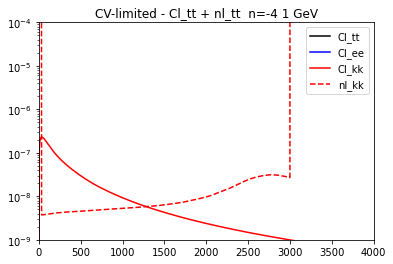

In [28]:
plt.plot(fiducial['tt'], 'k-',label="Cl_tt")
plt.plot(fiducial['ee'], 'b-',label="Cl_ee")
plt.plot(Cl_est_kk, 'r-',label="Cl_kk")
plt.plot(nl_kk , 'r--',label="nl_kk")
plt.yscale('log')
#plt.xscale('log')
plt.ylim(1e-9,1e-4)
plt.xlim(0,4000)
plt.legend(loc="upper right")
plt.title('CV-limited - Cl_tt + nl_tt  n=-4 1 GeV')
plt.show()

In [6]:
Nl_kk[1000]

5.294066760087947e-09

In [7]:
#For right and left C_l's:
def utility_function_call_CLASS(input_dict, l_max=4000):
    """Compute Cl with this utility function, repeat less code."""
    cosmo = Class()
    cosmo.set(input_dict)
    cosmo.compute()
    temp_cl = cosmo.raw_cl(l_max)
    cosmo.struct_cleanup()
    cosmo.empty()
    return temp_cl

In [8]:
def compute_derivative(params, theta, XY, stepsize, fiduc):
    left_params = params.copy()
    if theta == 'sigma_dmb':
        left_params[theta] = params[theta]
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (stepsize)
    else:
        left_params[theta] = params[theta] - stepsize
        right_params = params.copy()
        right_params[theta] = params[theta] + stepsize

        # get the C_l^XY and then compute the derivative!
        cl_XY_left = utility_function_call_CLASS(left_params)[XY]
        cl_XY_right = utility_function_call_CLASS(right_params)[XY]
        dClXY_dparam = (cl_XY_right - cl_XY_left) / (2 * stepsize)

    return dClXY_dparam / fiduc[XY], dClXY_dparam

def compute_d_cl(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl

def compute_d_cl_der_map(list_param_step, params, XY, fiducial):
    der_map = {}
    d_cl = {}
    for (par, stepsize) in list_param_step:
        norm_derivative, derivative = compute_derivative(params, par, XY, stepsize, fiducial)
        der_map[par] = norm_derivative
        d_cl[par] = derivative
    return d_cl, der_map

In [9]:
'''#Plotting Derivatives
dict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, 'tt', fiducial)
fig, axs = plt.subplots(2, 4, figsize=(10,4))
axs[0, 0].plot(dict_norm_der['omega_b'])
axs[0, 0].set_title('omega_b')
axs[0, 1].plot(dict_norm_der['omega_dmb'], 'tab:orange')
axs[0, 1].set_title(r'$\Omega_{dmb}$')
axs[0, 2].plot(dict_norm_der['h'], 'tab:brown')
axs[0, 2].set_title('h')
axs[0, 3].plot(dict_norm_der['A_s'], 'tab:green')
axs[0, 3].set_title('A_s')
axs[1, 0].plot(dict_norm_der['n_s'], 'tab:purple')
axs[1, 0].set_title(r'$n_s$')
axs[1, 1].plot(dict_norm_der['tau_reio'], 'tab:red')
axs[1, 1].set_title(r'$\tau$')
axs[1, 2].plot(dict_norm_der['sigma_dmb'], 'tab:red')
axs[1, 2].set_title('sigma_dmb')
for ax in axs.flat:
    ax.set(xlabel=r'$\ell$', ylabel=r'$(\partial C_{\ell}^{TT} / \partial \theta_i) / C_{\ell}^{TT}$')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
fig.savefig("fisher_plots/derivative_C_l_TT_{}GeV_n=2_cv-limited.png".format(str(dm_mass)))'''

'#Plotting Derivatives\ndict_params, dict_norm_der = compute_d_cl_der_map(list_param_step, params, \'tt\', fiducial)\nfig, axs = plt.subplots(2, 4, figsize=(10,4))\naxs[0, 0].plot(dict_norm_der[\'omega_b\'])\naxs[0, 0].set_title(\'omega_b\')\naxs[0, 1].plot(dict_norm_der[\'omega_dmb\'], \'tab:orange\')\naxs[0, 1].set_title(r\'$\\Omega_{dmb}$\')\naxs[0, 2].plot(dict_norm_der[\'h\'], \'tab:brown\')\naxs[0, 2].set_title(\'h\')\naxs[0, 3].plot(dict_norm_der[\'A_s\'], \'tab:green\')\naxs[0, 3].set_title(\'A_s\')\naxs[1, 0].plot(dict_norm_der[\'n_s\'], \'tab:purple\')\naxs[1, 0].set_title(r\'$n_s$\')\naxs[1, 1].plot(dict_norm_der[\'tau_reio\'], \'tab:red\')\naxs[1, 1].set_title(r\'$\tau$\')\naxs[1, 2].plot(dict_norm_der[\'sigma_dmb\'], \'tab:red\')\naxs[1, 2].set_title(\'sigma_dmb\')\nfor ax in axs.flat:\n    ax.set(xlabel=r\'$\\ell$\', ylabel=r\'$(\\partial C_{\\ell}^{TT} / \\partial \theta_i) / C_{\\ell}^{TT}$\')\n# Hide x labels and tick labels for top plots and y ticks for right plots.\n

In [10]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 61.83226490020752 seconds ---


We need:
 
$$ F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left( \mathbf{C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \mathbf{C}_{\ell}^{-1} \frac{\mathbf{C}_{\ell}}{\partial \theta_j} \right)$$
[Wu et al. 2014](https://arxiv.org/abs/1402.4108)





Let :
$$   \mathbf{Q}^{i}_{nm} =\, \left( {C}_{\ell}^{-1} \frac{\partial \mathbf{C}_{\ell}}{\partial \theta_i} \right)  =
  \left( {\begin{array}{cc}
    C_{\ell}^{TT} + N_{\ell}^{TT} & C_{\ell}^{TE} & 0 \\
   C_{\ell}^{TE} & C_{\ell}^{EE} + N_{\ell}^{EE} & 0 \\
   0 & 0 & C_{\ell}^{\kappa\kappa} + N_{\ell}^{\kappa\kappa} \\
  \end{array} } \right)^{-1}
   \left( {\begin{array}{cc}
    \frac{\partial C_{\ell}^{TT}}{\partial \theta_i } & \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } & 0 \\
   \frac{\partial C_{\ell}^{TE}}{\partial \theta_i } &\frac{\partial C_{\ell}^{EE}}{\partial \theta_i } & 0 \\
    0 & 0 & \frac{\partial C_{\ell}^{\kappa\kappa}}{\partial \theta_i } \\
  \end{array} } \right)
$$
So that:
$$  F_{ij} = \sum_{\ell} \frac{2 \ell + 1}{2} f_{\mathrm{sky}} \mathrm{Tr}\,\left[  \mathbf{Q}_{i}  \mathbf{Q}_{j} \right]
$$

In [11]:
dC_lpp = compute_d_cl(list_param_step, params, 'pp', fiducial)

<ipython-input-8-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [12]:
dC_lkk = {}
for k, array in dC_lpp.items():
    list_a = []
    for l, a in enumerate(array):
        if l < 2:
            list_a.append(0)
        else:
            list_a.append((1.0/4) * (math.factorial(l+2)/math.factorial(l-2)) * a)        
    dC_lkk[k] = np.array(list_a)
#print(dC_lkk)

In [13]:
MAT_d_cl = [ 
            [compute_d_cl(list_param_step, params, 'tt', fiducial), compute_d_cl(list_param_step, params, 'te', fiducial), 0],
            [compute_d_cl(list_param_step, params, 'te', fiducial), compute_d_cl(list_param_step, params, 'ee', fiducial), 0],
            [0, 0, dC_lkk]
           ]

MAT_cl = [ [fiducial['tt'], fiducial['te'], 0], 
           [fiducial['te'], fiducial['ee'], 0],
           [0, 0,  Cl_est_kk + nl_kk ] ]

<ipython-input-8-7f0aee16fb63>:22: RuntimeWarning: invalid value encountered in true_divide
  return dClXY_dparam / fiduc[XY], dClXY_dparam


In [14]:
#for i in list_param:
def compute_Q_i(i, l):
    d_Cl_i = [[MAT_d_cl[0][0][i][l], MAT_d_cl[0][1][i][l], 0], 
              [MAT_d_cl[1][0][i][l], MAT_d_cl[1][1][i][l], 0],
              [0, 0, MAT_d_cl[2][2][i][l]]]
    
    cl = [[MAT_cl[0][0][l], MAT_cl[0][1][l], 0],
          [MAT_cl[1][0][l], MAT_cl[1][1][l], 0],
          [0, 0, MAT_cl[2][2][l]]]
    Q_i = np.matmul(inv(cl), d_Cl_i)
    return Q_i

def compute_F_ij(i, j):
    F_ij = 0
    for l in range(2, 4000):
        F_ij += 0.5*(2*l + 1) *f_sky * np.trace(np.matmul(compute_Q_i(i, l), compute_Q_i(j, l)))
    return F_ij

In [15]:
F =[]
for x in list_param:
    row = []
    for y in list_param:
        row.append(compute_F_ij(x, y))
    F.append(row)
    
covar = inv(F)
for n, i in enumerate(list_param):
    sigma_ii = np.sqrt(covar[n][n])
    print(i, sigma_ii)

omega_b 1.106898989168632e-05
omega_cdm 0.0001826175889197252
h 0.0006648854876500923
A_s 6.379837643010749e-12
n_s 0.0009324996425405589
tau_reio 0.001666032237761057
sigma_dmb 3.620991810234327e-28


In [16]:
print(F)

[[88136467762.2997, -13503503192.007187, -3049068504.633326, 3.6006452512809734e+17, 1226477512.161645, -1830039993.749327, 2.731501472852087e+32], [-13503503192.007187, 5096972699.016229, 614963356.9303999, 1.4548905033845842e+16, 117498203.97499306, 209619598.2788414, -4.3619656793903476e+32], [-3049068504.633326, 614963356.9303999, 211022633.99102888, -1.608449328881502e+16, -58221059.30639627, 55540447.98588106, 2.7311484252855642e+31], [3.6006452512809734e+17, 1.454890503384584e+16, -1.608449328881502e+16, 4.958676446281165e+24, 1.6900203472928556e+16, -1.4547918059525352e+16, -1.2496087723019675e+40], [1226477512.161645, 117498203.97499306, -58221059.30639627, 1.6900203472928556e+16, 64953101.23239059, -42923517.03136018, -5.785478183912774e+31], [-1830039993.749327, 209619598.2788414, 55540447.98588106, -1.4547918059525352e+16, -42923517.03136018, 64308524.3724467, 4.0375708913872976e+30], [2.731501472852087e+32, -4.361965679390346e+32, 2.7311484252855642e+31, -1.249608772301967

generating new axis
['omega_b', 'omega_cdm', 'h', 'A_s', 'n_s', 'tau_reio', 'sigma_dmb']


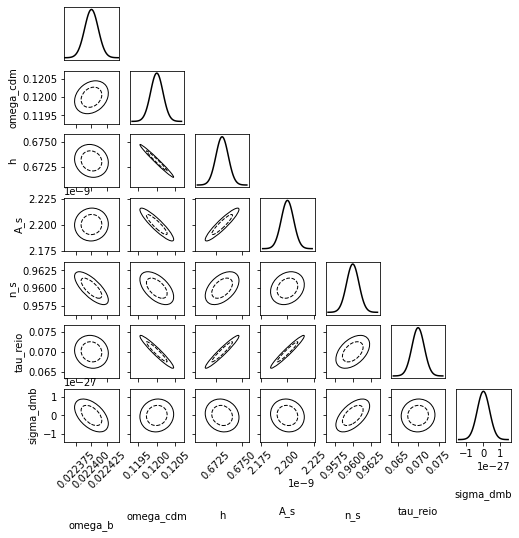

In [17]:
import fishchips.util
cov = np.linalg.inv(F)
fig, axes = fishchips.util.plot_triangle_base(list_param, list_fiducial, covar, labels=list_param);
fig.savefig("fisher_plots/triagular_ellipses_{}GeV_n=2_cv-limited.png".format(str(dm_mass)))

In [18]:
dat = ('n-power=',n_power,'dm_mass=', dm_mass, 'stepsize =', step_size_cross_section,'fisher matrix =', F,i, "from cov matrix =",sigma_ii,"2-sigma =" ,sigma_ii*2.48,"2-sigma zack's method =")

In [19]:
print(dat)

('n-power=', 0, 'dm_mass=', 1, 'stepsize =', 2e-26, 'fisher matrix =', [[88136467762.2997, -13503503192.007187, -3049068504.633326, 3.6006452512809734e+17, 1226477512.161645, -1830039993.749327, 2.731501472852087e+32], [-13503503192.007187, 5096972699.016229, 614963356.9303999, 1.4548905033845842e+16, 117498203.97499306, 209619598.2788414, -4.3619656793903476e+32], [-3049068504.633326, 614963356.9303999, 211022633.99102888, -1.608449328881502e+16, -58221059.30639627, 55540447.98588106, 2.7311484252855642e+31], [3.6006452512809734e+17, 1.454890503384584e+16, -1.608449328881502e+16, 4.958676446281165e+24, 1.6900203472928556e+16, -1.4547918059525352e+16, -1.2496087723019675e+40], [1226477512.161645, 117498203.97499306, -58221059.30639627, 1.6900203472928556e+16, 64953101.23239059, -42923517.03136018, -5.785478183912774e+31], [-1830039993.749327, 209619598.2788414, 55540447.98588106, -1.4547918059525352e+16, -42923517.03136018, 64308524.3724467, 4.0375708913872976e+30], [2.731501472852087e

In [20]:
outF = open("fisher_data/cv-limited_n={}/{}GeV.txt".format(str(n_power),str(dm_mass)), "w")

for i in dat:
  # write line to output file
  outF.write(str(i))
  outF.write("\n")
outF.close()

In [21]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 25000.101264715195 seconds ---
